# Classifiers - low vs mid vs high complexity - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.multiclass import OneVsRestClassifier


import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
#         if cog_res['task_complexity'][task_num_table] == 'medium':
#             continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }

        
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

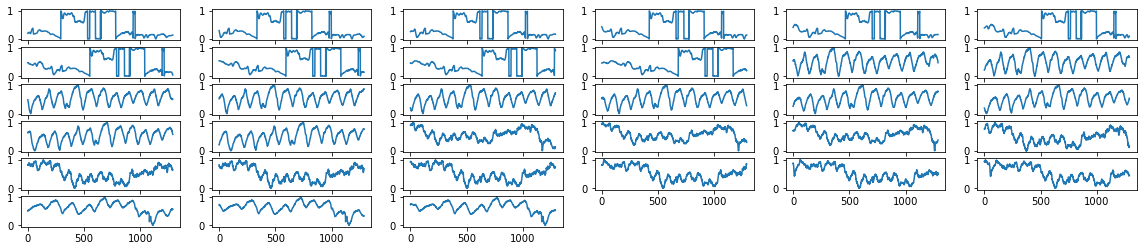

<Figure size 432x288 with 0 Axes>

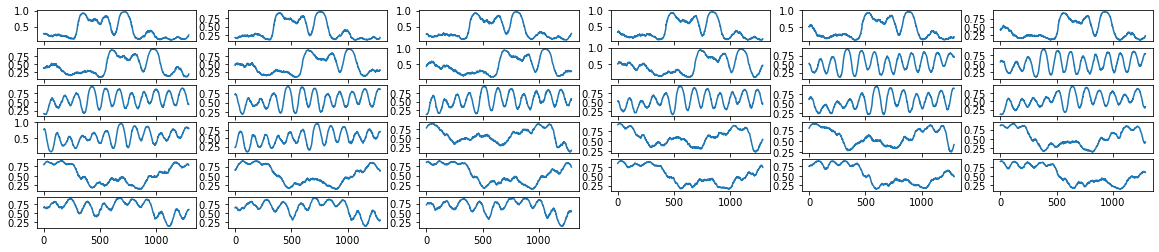

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

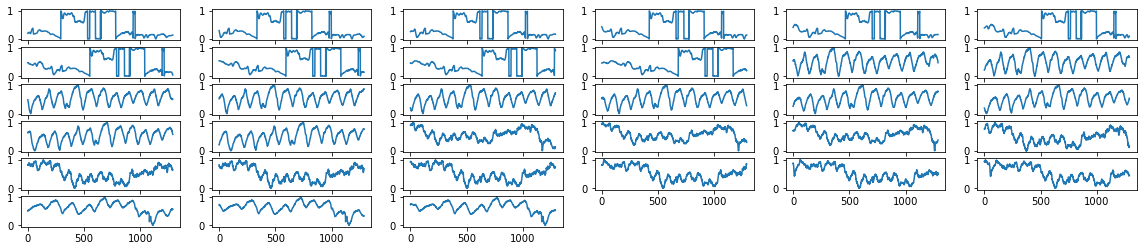

<Figure size 432x288 with 0 Axes>

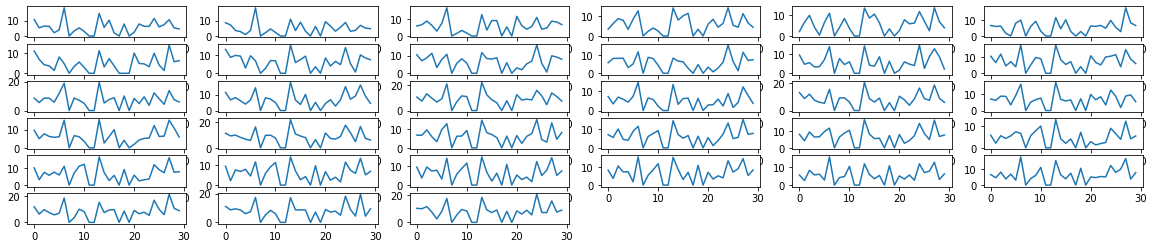

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

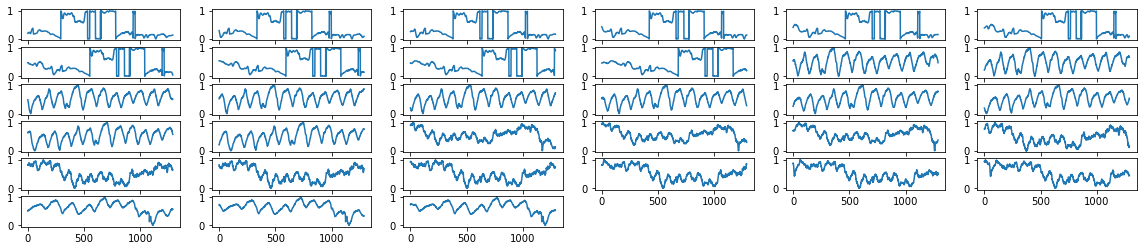

<Figure size 432x288 with 0 Axes>

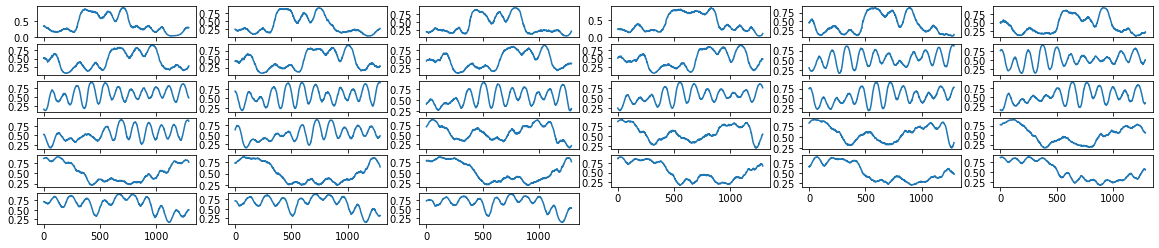

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

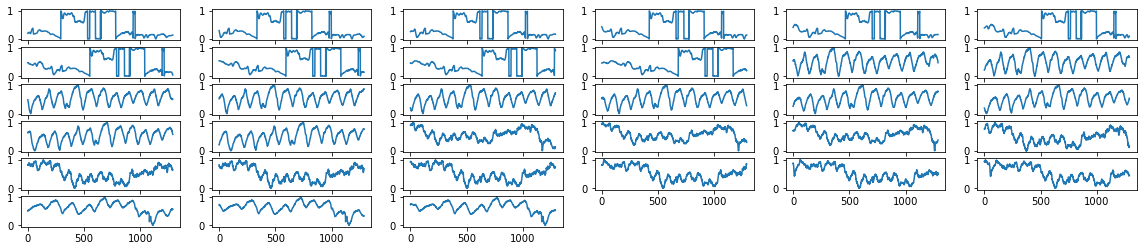

<Figure size 432x288 with 0 Axes>

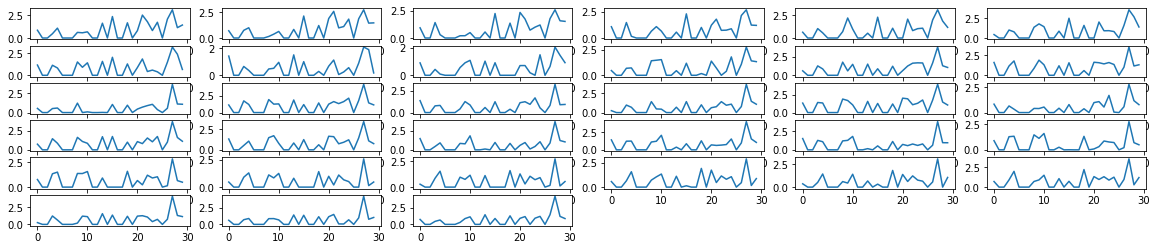

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

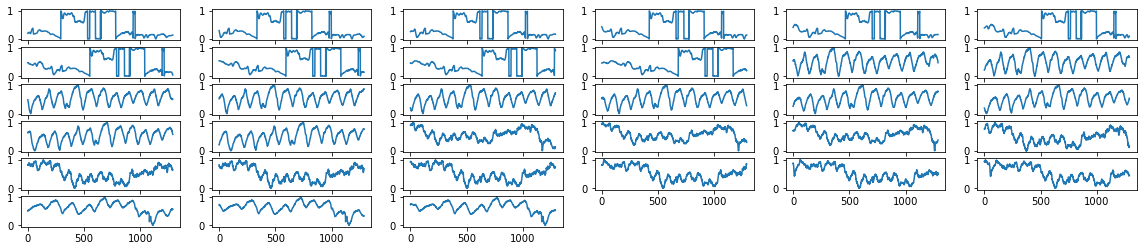

<Figure size 432x288 with 0 Axes>

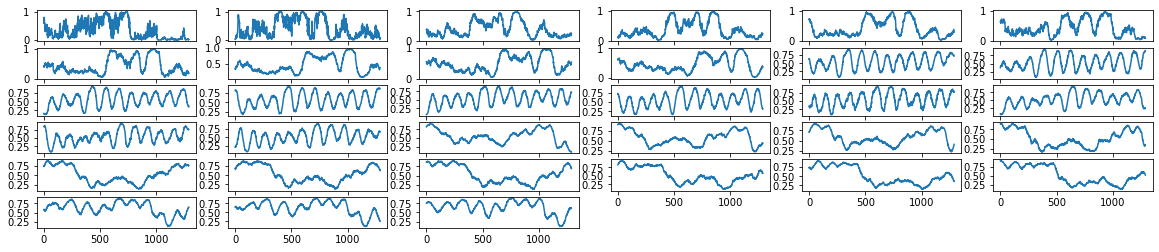

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

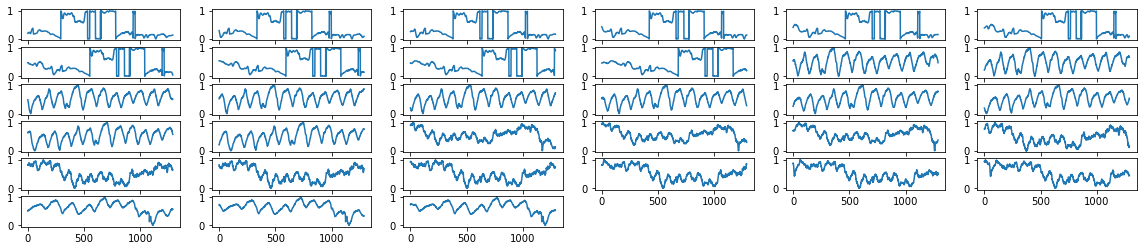

<Figure size 432x288 with 0 Axes>

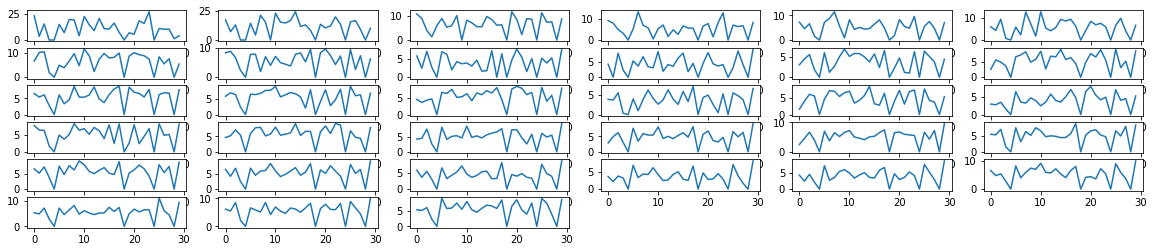

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                
                # scale phase in a different way than other features
                if (index == 1): 
                    # Scale each row with standard scaler
                    train_x = scale(train_x, axis=1)
                    valid_x = scale(valid_x, axis=1)
                    test_x = scale(test_x, axis=1)
                    # Scale each row with MinMax to range [0,1]
                    train_x = MinMaxScaler().fit_transform(train_x.T).T
                    valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                    test_x = MinMaxScaler().fit_transform(test_x.T).T
                else:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale with MinMax to range [0,1]
                    mmscaler = MinMaxScaler((0,1))
                    mmscaler.fit(train_x)
                    train_x = mmscaler.transform(train_x)

                    # Scale valid and test with train's scalers
                    valid_x = sscaler.transform(valid_x)
                    valid_x = mmscaler.transform(valid_x)
                    
                    test_x = sscaler.transform(test_x)
                    test_x = mmscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'categorical_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [33]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(dense_train, idents, n, num_loops_to_average_over=1)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:24.296545
iteration: 3 of 23 ; time elapsed: 0:00:48.453744
iteration: 4 of 23 ; time elapsed: 0:01:12.905054
iteration: 5 of 23 ; time elapsed: 0:01:37.802633
iteration: 6 of 23 ; time elapsed: 0:02:03.357277
iteration: 7 of 23 ; time elapsed: 0:02:28.169851
iteration: 8 of 23 ; time elapsed: 0:02:54.591648
iteration: 9 of 23 ; time elapsed: 0:03:19.764685
iteration: 10 of 23 ; time elapsed: 0:03:45.371373
iteration: 11 of 23 ; time elapsed: 0:04:11.641075
iteration: 12 of 23 ; time elapsed: 0:04:36.525991
iteration: 13 of 23 ; time elapsed: 0:05:01.336100
iteration: 14 of 23 ; time elapsed: 0:05:26.177934
iteration: 15 of 23 ; time elapsed: 0:05:50.911532
iteration: 16 of 23 ; time elapsed: 0:06:15.781350
iteration: 17 of 23 ; time elapsed: 0:06:40.489687
iteration: 18 of 23 ; time elapsed: 0:07:05.477432
iteration: 19 of 23 ; time elapsed: 0:07:30.736146
iteration: 20 of 23 ; time elapsed: 0:07:55.986

In [35]:
accuracies['simple_dense'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.327778,0.344444,0.333333,0.338889,0.172222,0.294444,0.288889,62i9y
1,0.405556,0.383333,0.350000,0.277778,0.361111,0.355556,0.333333,2gu87
2,0.361111,0.305556,0.355556,0.194444,0.366667,0.394444,0.333333,iz2ps
3,0.294444,0.272222,0.255556,0.244444,0.216667,0.350000,0.244444,1mpau
4,0.305556,0.261111,0.283333,0.244444,0.283333,0.333333,0.338889,7dwjy
5,0.372222,0.294444,0.377778,0.266667,0.383333,0.305556,0.333333,7swyk
6,0.488889,0.355556,0.311111,0.411111,0.411111,0.566667,0.427778,94mnx
7,0.422222,0.500000,0.227778,0.466667,0.227778,0.283333,0.266667,bd47a
8,0.327778,0.344444,0.322222,0.327778,0.355556,0.333333,0.366667,c24ur
9,0.322222,0.294444,0.316667,0.272222,0.150000,0.261111,0.244444,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.211111   0.194444        0.188889       0.150000  0.261111  0.177778
max     0.488889   0.500000   0.438889        0.466667       0.450000  0.566667  0.444444
mean    0.334300   0.313285   0.323671        0.308213       0.308454  0.339130  0.320290
median  0.327778   0.305556   0.322222        0.305556       0.316667  0.344444  0.333333


#### LSTM-based classifier  
based on the original author's code

In [38]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [39]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [40]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(3))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:03:20.669429
iteration: 3 of 23 ; time elapsed: 0:06:41.732793
iteration: 4 of 23 ; time elapsed: 0:09:57.399185
iteration: 5 of 23 ; time elapsed: 0:13:28.331450
iteration: 6 of 23 ; time elapsed: 0:17:01.481895
iteration: 7 of 23 ; time elapsed: 0:20:36.485351
iteration: 8 of 23 ; time elapsed: 0:24:08.570796
iteration: 9 of 23 ; time elapsed: 0:27:40.104873
iteration: 10 of 23 ; time elapsed: 0:31:10.028871
iteration: 11 of 23 ; time elapsed: 0:34:43.875620
iteration: 12 of 23 ; time elapsed: 0:38:14.858816
iteration: 13 of 23 ; time elapsed: 0:41:47.761214
iteration: 14 of 23 ; time elapsed: 0:45:22.646280
iteration: 15 of 23 ; time elapsed: 0:48:49.629576
iteration: 16 of 23 ; time elapsed: 0:52:15.719950
iteration: 17 of 23 ; time elapsed: 0:55:50.557799
iteration: 18 of 23 ; time elapsed: 0:59:22.775638
iteration: 19 of 23 ; time elapsed: 1:02:51.673692
iteration: 20 of 23 ; time elapsed: 1:06:22.762

In [42]:
accuracies['LSTM'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.227778,0.350000,0.422222,0.338889,0.266667,0.238889,0.266667,62i9y
1,0.472222,0.294444,0.361111,0.422222,0.283333,0.311111,0.388889,2gu87
2,0.200000,0.266667,0.333333,0.300000,0.344444,0.272222,0.222222,iz2ps
3,0.355556,0.205556,0.266667,0.222222,0.300000,0.338889,0.361111,1mpau
4,0.394444,0.444444,0.305556,0.377778,0.444444,0.333333,0.288889,7dwjy
5,0.344444,0.305556,0.333333,0.288889,0.388889,0.316667,0.305556,7swyk
6,0.333333,0.350000,0.283333,0.327778,0.466667,0.388889,0.427778,94mnx
7,0.411111,0.366667,0.355556,0.366667,0.355556,0.316667,0.222222,bd47a
8,0.272222,0.338889,0.283333,0.300000,0.216667,0.355556,0.333333,c24ur
9,0.305556,0.355556,0.327778,0.283333,0.377778,0.361111,0.377778,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.194444   0.183333   0.244444        0.222222       0.166667  0.227778  0.205556
max     0.472222   0.450000   0.422222        0.422222       0.466667  0.411111  0.427778
mean    0.320773   0.323188   0.331159        0.320531       0.334300  0.323430  0.325845
median  0.322222   0.350000   0.327778        0.327778       0.344444  0.333333  0.333333


#### kNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [46]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(KNN_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [47]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.863833
iteration: 3 of 23 ; time elapsed: 0:00:01.694157
iteration: 4 of 23 ; time elapsed: 0:00:02.522157
iteration: 5 of 23 ; time elapsed: 0:00:03.352634
iteration: 6 of 23 ; time elapsed: 0:00:04.182690
iteration: 7 of 23 ; time elapsed: 0:00:05.041386
iteration: 8 of 23 ; time elapsed: 0:00:05.870432
iteration: 9 of 23 ; time elapsed: 0:00:06.735492
iteration: 10 of 23 ; time elapsed: 0:00:07.585927
iteration: 11 of 23 ; time elapsed: 0:00:08.412944
iteration: 12 of 23 ; time elapsed: 0:00:09.362999
iteration: 13 of 23 ; time elapsed: 0:00:10.300056
iteration: 14 of 23 ; time elapsed: 0:00:11.231752
iteration: 15 of 23 ; time elapsed: 0:00:12.125205
iteration: 16 of 23 ; time elapsed: 0:00:13.004994
iteration: 17 of 23 ; time elapsed: 0:00:13.839943
iteration: 18 of 23 ; time elapsed: 0:00:14.692639
iteration: 19 of 23 ; time elapsed: 0:00:15.537953
iteration: 20 of 23 ; time elapsed: 0:00:16.388

In [48]:
accuracies['kNN'] = accs

In [49]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.311111,0.344444,0.244444,0.294444,0.305556,0.488889,0.322222,62i9y
1,0.350000,0.277778,0.316667,0.277778,0.350000,0.316667,0.344444,2gu87
2,0.355556,0.338889,0.294444,0.427778,0.377778,0.366667,0.333333,iz2ps
3,0.350000,0.355556,0.405556,0.327778,0.333333,0.383333,0.333333,1mpau
4,0.366667,0.283333,0.350000,0.277778,0.383333,0.355556,0.350000,7dwjy
5,0.283333,0.322222,0.311111,0.272222,0.361111,0.333333,0.394444,7swyk
6,0.338889,0.355556,0.288889,0.444444,0.350000,0.333333,0.388889,94mnx
7,0.438889,0.327778,0.394444,0.272222,0.305556,0.366667,0.338889,bd47a
8,0.327778,0.283333,0.416667,0.455556,0.411111,0.322222,0.338889,c24ur
9,0.294444,0.211111,0.350000,0.277778,0.300000,0.283333,0.372222,ctsax


In [50]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.183333   0.211111   0.244444        0.177778       0.233333  0.244444  0.244444
max     0.533333   0.394444   0.444444        0.477778       0.411111  0.488889  0.411111
mean    0.342754   0.310870   0.334300        0.323913       0.326812  0.342754  0.345894
median  0.338889   0.311111   0.333333        0.277778       0.322222  0.333333  0.344444


####  SVC

In [51]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [52]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(SVC_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(SVC_train, idents, n, num_loops_to_average_over=1)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:03.726596
iteration: 3 of 23 ; time elapsed: 0:02:07.713582
iteration: 4 of 23 ; time elapsed: 0:03:11.353494
iteration: 5 of 23 ; time elapsed: 0:04:15.001422
iteration: 6 of 23 ; time elapsed: 0:05:18.700399
iteration: 7 of 23 ; time elapsed: 0:06:22.297849
iteration: 8 of 23 ; time elapsed: 0:07:25.993224
iteration: 9 of 23 ; time elapsed: 0:08:29.201006
iteration: 10 of 23 ; time elapsed: 0:09:32.607788
iteration: 11 of 23 ; time elapsed: 0:10:35.781694
iteration: 12 of 23 ; time elapsed: 0:11:39.163370
iteration: 13 of 23 ; time elapsed: 0:12:41.472199
iteration: 14 of 23 ; time elapsed: 0:13:43.854758
iteration: 15 of 23 ; time elapsed: 0:14:46.869477
iteration: 16 of 23 ; time elapsed: 0:15:49.965308
iteration: 17 of 23 ; time elapsed: 0:16:53.866526
iteration: 18 of 23 ; time elapsed: 0:17:56.867437
iteration: 19 of 23 ; time elapsed: 0:18:59.740464
iteration: 20 of 23 ; time elapsed: 0:20:02.711

In [54]:
accuracies['SVC'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.277778,0.394444,0.450000,0.388889,0.361111,0.144444,0.172222,62i9y
1,0.438889,0.322222,0.516667,0.466667,0.305556,0.344444,0.316667,2gu87
2,0.311111,0.233333,0.238889,0.327778,0.294444,0.294444,0.294444,iz2ps
3,0.322222,0.272222,0.300000,0.277778,0.344444,0.366667,0.427778,1mpau
4,0.266667,0.361111,0.333333,0.488889,0.255556,0.283333,0.227778,7dwjy
5,0.300000,0.244444,0.316667,0.272222,0.494444,0.333333,0.261111,7swyk
6,0.461111,0.472222,0.211111,0.383333,0.388889,0.372222,0.377778,94mnx
7,0.461111,0.422222,0.400000,0.405556,0.261111,0.333333,0.311111,bd47a
8,0.350000,0.377778,0.455556,0.405556,0.172222,0.172222,0.344444,c24ur
9,0.416667,0.450000,0.244444,0.272222,0.394444,0.405556,0.300000,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.211111   0.183333   0.211111        0.188889       0.172222  0.144444  0.172222
max     0.500000   0.505556   0.533333        0.594444       0.494444  0.416667  0.427778
mean    0.345411   0.350725   0.340338        0.360145       0.330676  0.322705  0.320531
median  0.338889   0.361111   0.316667        0.355556       0.327778  0.338889  0.311111


#### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [58]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(random_forest_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False, num_loops_to_average_over=1)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:30.248132
iteration: 3 of 23 ; time elapsed: 0:02:55.973657
iteration: 4 of 23 ; time elapsed: 0:04:24.154171
iteration: 5 of 23 ; time elapsed: 0:05:52.650390
iteration: 6 of 23 ; time elapsed: 0:07:21.273362
iteration: 7 of 23 ; time elapsed: 0:08:51.811955
iteration: 8 of 23 ; time elapsed: 0:10:28.121803
iteration: 9 of 23 ; time elapsed: 0:11:59.764746
iteration: 10 of 23 ; time elapsed: 0:13:31.009832
iteration: 11 of 23 ; time elapsed: 0:15:06.390451
iteration: 12 of 23 ; time elapsed: 0:16:40.528572
iteration: 13 of 23 ; time elapsed: 0:18:17.380498
iteration: 14 of 23 ; time elapsed: 0:19:50.909909
iteration: 15 of 23 ; time elapsed: 0:21:20.505593
iteration: 16 of 23 ; time elapsed: 0:22:52.950496
iteration: 17 of 23 ; time elapsed: 0:24:23.667841
iteration: 18 of 23 ; time elapsed: 0:25:58.281194
iteration: 19 of 23 ; time elapsed: 0:27:33.563510
iteration: 20 of 23 ; time elapsed: 0:29:04.461

In [60]:
accuracies['random_forest'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.344444,0.383333,0.383333,0.472222,0.322222,0.350000,0.383333,62i9y
1,0.283333,0.383333,0.394444,0.294444,0.261111,0.288889,0.216667,2gu87
2,0.388889,0.322222,0.150000,0.255556,0.316667,0.383333,0.372222,iz2ps
3,0.522222,0.472222,0.322222,0.277778,0.327778,0.377778,0.377778,1mpau
4,0.294444,0.316667,0.361111,0.372222,0.300000,0.294444,0.288889,7dwjy
5,0.188889,0.238889,0.411111,0.288889,0.250000,0.183333,0.244444,7swyk
6,0.455556,0.416667,0.377778,0.427778,0.238889,0.283333,0.294444,94mnx
7,0.361111,0.366667,0.466667,0.344444,0.244444,0.411111,0.355556,bd47a
8,0.227778,0.266667,0.422222,0.361111,0.183333,0.244444,0.227778,c24ur
9,0.388889,0.277778,0.238889,0.211111,0.388889,0.400000,0.383333,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.188889   0.238889   0.150000        0.200000       0.183333  0.183333  0.216667
max     0.522222   0.472222   0.466667        0.472222       0.427778  0.511111  0.438889
mean    0.355072   0.343961   0.337440        0.336957       0.300242  0.334541  0.315217
median  0.366667   0.333333   0.355556        0.350000       0.311111  0.333333  0.316667


#### Naive Bayesian

In [63]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [64]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(naive_bayesian_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [65]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.408495
iteration: 3 of 23 ; time elapsed: 0:00:00.824751
iteration: 4 of 23 ; time elapsed: 0:00:01.235684
iteration: 5 of 23 ; time elapsed: 0:00:01.640417
iteration: 6 of 23 ; time elapsed: 0:00:02.046365
iteration: 7 of 23 ; time elapsed: 0:00:02.481203
iteration: 8 of 23 ; time elapsed: 0:00:02.879246
iteration: 9 of 23 ; time elapsed: 0:00:03.273118
iteration: 10 of 23 ; time elapsed: 0:00:03.673814
iteration: 11 of 23 ; time elapsed: 0:00:04.080010
iteration: 12 of 23 ; time elapsed: 0:00:04.497891
iteration: 13 of 23 ; time elapsed: 0:00:04.907296
iteration: 14 of 23 ; time elapsed: 0:00:05.317706
iteration: 15 of 23 ; time elapsed: 0:00:05.771628
iteration: 16 of 23 ; time elapsed: 0:00:06.176545
iteration: 17 of 23 ; time elapsed: 0:00:06.570492
iteration: 18 of 23 ; time elapsed: 0:00:07.097940
iteration: 19 of 23 ; time elapsed: 0:00:07.506458
iteration: 20 of 23 ; time elapsed: 0:00:07.903

In [66]:
accuracies['naive_bayesian'] = accs

In [67]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.300000,0.338889,0.311111,0.327778,0.333333,0.322222,0.333333,62i9y
1,0.405556,0.344444,0.294444,0.333333,0.333333,0.327778,0.283333,2gu87
2,0.311111,0.305556,0.344444,0.305556,0.366667,0.377778,0.311111,iz2ps
3,0.472222,0.227778,0.288889,0.233333,0.222222,0.211111,0.316667,1mpau
4,0.383333,0.294444,0.272222,0.300000,0.361111,0.350000,0.338889,7dwjy
5,0.333333,0.250000,0.383333,0.261111,0.394444,0.266667,0.394444,7swyk
6,0.627778,0.333333,0.255556,0.344444,0.250000,0.377778,0.350000,94mnx
7,0.255556,0.322222,0.277778,0.383333,0.350000,0.244444,0.216667,bd47a
8,0.333333,0.377778,0.394444,0.327778,0.388889,0.322222,0.311111,c24ur
9,0.372222,0.250000,0.322222,0.177778,0.222222,0.155556,0.250000,ctsax


In [68]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.188889   0.227778   0.177778        0.177778       0.222222  0.155556  0.216667
max     0.627778   0.488889   0.433333        0.483333       0.394444  0.422222  0.394444
mean    0.351691   0.315700   0.305072        0.314976       0.325845  0.315459  0.322947
median  0.333333   0.311111   0.305556        0.316667       0.333333  0.327778  0.322222


#### XGBoost

In [69]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [70]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(XGBoost_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False, num_loops_to_average_over=1)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:40.551879
iteration: 3 of 23 ; time elapsed: 0:01:19.293824
iteration: 4 of 23 ; time elapsed: 0:01:58.273091
iteration: 5 of 23 ; time elapsed: 0:02:36.511491
iteration: 6 of 23 ; time elapsed: 0:03:14.162506
iteration: 7 of 23 ; time elapsed: 0:03:51.623935
iteration: 8 of 23 ; time elapsed: 0:04:28.972759
iteration: 9 of 23 ; time elapsed: 0:05:06.242720
iteration: 10 of 23 ; time elapsed: 0:05:41.578659
iteration: 11 of 23 ; time elapsed: 0:06:15.787224
iteration: 12 of 23 ; time elapsed: 0:06:51.295517
iteration: 13 of 23 ; time elapsed: 0:07:26.315085
iteration: 14 of 23 ; time elapsed: 0:08:02.763793
iteration: 15 of 23 ; time elapsed: 0:08:38.066770
iteration: 16 of 23 ; time elapsed: 0:09:14.370738
iteration: 17 of 23 ; time elapsed: 0:09:49.229688
iteration: 18 of 23 ; time elapsed: 0:10:26.761899
iteration: 19 of 23 ; time elapsed: 0:11:03.901460
iteration: 20 of 23 ; time elapsed: 0:11:39.644

In [72]:
accuracies['XGBoost'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.394444,0.388889,0.383333,0.433333,0.322222,0.350000,0.344444,62i9y
1,0.233333,0.322222,0.372222,0.350000,0.283333,0.316667,0.283333,2gu87
2,0.316667,0.344444,0.183333,0.411111,0.355556,0.394444,0.344444,iz2ps
3,0.511111,0.516667,0.311111,0.322222,0.400000,0.394444,0.355556,1mpau
4,0.277778,0.288889,0.383333,0.300000,0.344444,0.288889,0.338889,7dwjy
5,0.250000,0.300000,0.427778,0.344444,0.277778,0.272222,0.238889,7swyk
6,0.377778,0.411111,0.361111,0.366667,0.266667,0.316667,0.338889,94mnx
7,0.333333,0.361111,0.472222,0.383333,0.300000,0.422222,0.355556,bd47a
8,0.261111,0.338889,0.411111,0.405556,0.211111,0.238889,0.266667,c24ur
9,0.377778,0.283333,0.255556,0.227778,0.388889,0.377778,0.366667,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.205556   0.244444   0.183333        0.194444       0.211111  0.238889  0.238889
max     0.511111   0.516667   0.472222        0.494444       0.427778  0.466667  0.400000
mean    0.341546   0.347343   0.347585        0.354589       0.320048  0.338647  0.316184
median  0.338889   0.333333   0.355556        0.350000       0.311111  0.333333  0.322222


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [75]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.211111   0.194444        0.188889       0.150000  0.261111  0.177778
max     0.488889   0.500000   0.438889        0.466667       0.450000  0.566667  0.444444
mean    0.334300   0.313285   0.323671        0.308213       0.308454  0.339130  0.320290
median  0.327778   0.305556   0.322222        0.305556       0.316667  0.344444  0.333333


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.194444   0.183333   0.244444        0.222222       0.166667  0.227778  0.205556
max     0.472222   0.450000   0.422222        0.422222       0.466667  0.411111  0.427778
mean    0.320773   0.323188   0.331159        0.320531       0.334300  0.323430  0.325845
median  0.322222   0.350000   0.327778        0.327778       0.344444  0.333333  0.333333


----------- kNN: -----------

Print all accuracies in table form:

In [76]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.327778   0.344444   0.333333        0.338889       0.172222  0.294444  0.288889   62i9y
1   0.405556   0.383333   0.350000        0.277778       0.361111  0.355556  0.333333   2gu87
2   0.361111   0.305556   0.355556        0.194444       0.366667  0.394444  0.333333   iz2ps
3   0.294444   0.272222   0.255556        0.244444       0.216667  0.350000  0.244444   1mpau
4   0.305556   0.261111   0.283333        0.244444       0.283333  0.333333  0.338889   7dwjy
5   0.372222   0.294444   0.377778        0.266667       0.383333  0.305556  0.333333   7swyk
6   0.488889   0.355556   0.311111        0.411111       0.411111  0.566667  0.427778   94mnx
7   0.422222   0.500000   0.227778        0.466667       0.227778  0.283333  0.266667   bd47a
8   0.327778   0.344444   0.322222        0.327778       0.355556  0.333333  0.366667   c24ur
9   0.322222   0.294444   0.316667        0.27